After reading chapter 2 of book I reached the Try it out section of the book. I am to pick any dataset I want and use it to practice the data science cycle taught by this chapter.
I chose kaggle titanic dataset. The goal is to "use machine learning to create a model that predicts which passengers survived the Titanic shipwreck."

In [2]:
import kaggle
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import numpy as np

In [3]:
def load_titanic_train_test_set():
    if not Path("datasets/titanic").is_dir():
        Path("datasets").mkdir(exist_ok=True)
        kaggle.api.authenticate()
        kaggle.api.competition_download_files("titanic", path="./datasets", force=False, quiet=True)
    
        with ZipFile("datasets/titanic.zip", 'r') as titanic_zip:
            titanic_zip.extractall("datasets/titanic")
    
    return pd.read_csv("datasets/titanic/train.csv", index_col="PassengerId"), pd.read_csv("datasets/titanic/test.csv",index_col="PassengerId")


In [4]:
train, test = load_titanic_train_test_set()

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (891, 11)
Test shape: (418, 10)


## Explore Data

In [5]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


    Convert sex to a binary type column
    Age has missing values
    cabin has a lot of missing values, see correlation with survived
    find out what is relevant in name and ticket (if they are relevant)
    

In [7]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [28]:
# inspect non-null cabin values
train["Cabin"].value_counts() # when Pclass == 1

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

Assuming the letter of the Cabin number represents the deck or section of boat where the cabin was located followed by the room number

In [63]:
# is the training set unbalanced?
pd.concat([train["Survived"].value_counts(), (train["Survived"].value_counts() / train["Survived"].count()).round(2)], axis=1) # a little

,count,count
Survived,,
0,549,0.62
1,342,0.38


Word clouds look like a good way to see if there is any pattern between survivors and their names and non-survivors and their names

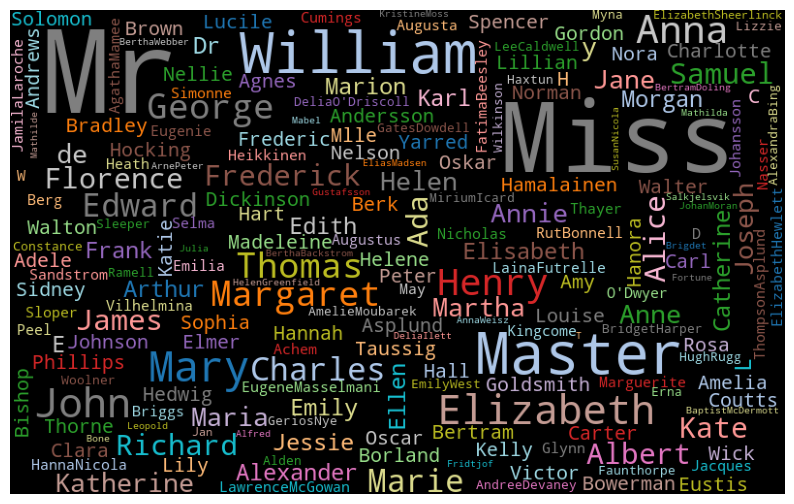

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

indexes_survived = train["Survived"] == 1
all_survivors_names = "".join([ name for name in train[indexes_survived]["Name"]])
word_cloud = WordCloud(width=800, height=500, random_state=42, max_font_size=120, colormap="tab20").generate(all_survivors_names)

plt.figure(figsize=(10,7))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

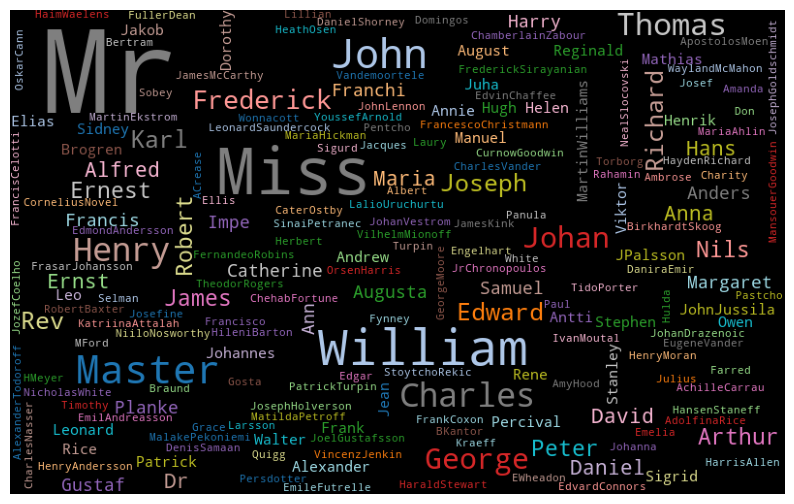

In [60]:
indexes_not_survived = train["Survived"] == 0
all_non_survivors_names = "".join([ name for name in train[indexes_not_survived]["Name"]])
word_cloud2 = WordCloud(width=800, height=500, random_state=42, max_font_size=120, colormap="tab20").generate(all_non_survivors_names)

plt.figure(figsize=(10,7))
plt.imshow(word_cloud2)
plt.axis("off")
plt.show()

I was hoping that some prefixes would be correlated to chance of survival but, after a lot of inspection, names do not seem to have any correlation at all. Name column will be dropped then.

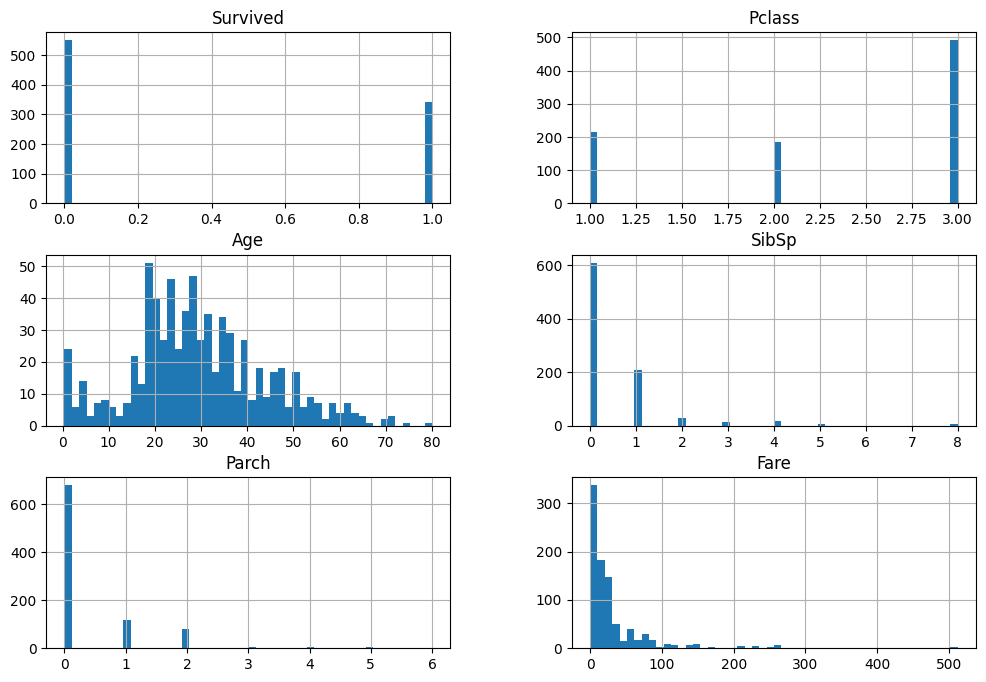

In [67]:
# visualizing numeric data
train.hist(bins=50, figsize=(12,8))

plt.show()